# echopype Tour

[https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/](https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/)

A quick tour of core [echopype](https://echopype.readthedocs.io/) capabilities.

## Introduction

### Goals

- Illustrate a common workflow for echosounder data conversion, calibration and use. This workflow leverages the standardization applied by echopype and the power, ease of use and familiarity of libraries in the scientific Python ecosystem. 
- Extract and visualize data with relative ease. 

### Description

This notebook uses EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a common workflow for data conversion, calibration and analysis using [`echopype`](https://echopype.readthedocs.io) and core scientific Python software packages, particularly `xarray`, `GeoPandas` and `pandas`. 

Two days of cloud-hosted `.raw` data files are accessed by echopype directly from an [Amazon Web Services (AWS)](https://aws.amazon.com/) S3 "bucket" maintained by the [NOAA NCEI Water-Column Sonar Data Archive](https://registry.opendata.aws/ncei-wcsd-archive/). With `echopype`, each file is converted to a standardized representation based on the [SONAR-netCDF4 v1.0 convention](https://github.com/ices-publications/SONAR-netCDF4/) and saved to the Zarr cloud-optimized file format. 

Data stored in the Zarr (or netCDF) file format using the SONAR-netCDF4 convention can be conveniently and intuitively manipulated with `xarray` in combination with related scientific Python packages. [Mean Volume Backscattering Strength (MVBS)](http://www.fao.org/3/X5818E/x5818e07.htm) is computed with `echopype` from the combined, converted raw data files, after calibration. The GPS location track and MVBS echograms are visualized.

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/binder/environment.yml. The notebook creates the `./exports` directory, if not already present. Zarr files will be exported there.

In [1]:
from pathlib import Path

import fsspec
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import hvplot.xarray

import echopype as ep

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Compile list of raw files to read from the NCEI WCSD S3 bucket

We'll compile a list of several EK60 `.raw` files from the 2017 Pacific Hake survey, available via open, anonymous access from an AWS S3 bucket managed by the NCEI WCSD.

After using `fsspec` to establish an S3 "file system" access point, extract a list of `.raw` files in the target directory.

In [2]:
fs = fsspec.filesystem('s3', anon=True)

bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

In [3]:
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")

In [4]:
print(f"There are {len(s3rawfiles)} raw files in the directory")

There are 4343 raw files in the directory


In [5]:
# print out the last two S3 raw file paths in the list
s3rawfiles[-2:]

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170913-T180733.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Winter2017-D20170615-T002629.raw']

Each of these `.raw` files is typically about 25 MB. To select a reasonably small but meaningful target for this demo, let's select all files from 2017-07-28 collected over a two hour period, 18:00 to 19:59 UTC. This is done through string matching on the time stamps found in the file names.

In [6]:
s3rawfiles = [
    s3path for s3path in s3rawfiles 
    if any([f"D2017{dtstr}" in s3path for dtstr in ['0728-T18', '0728-T19']])
]

print(f"There are {len(s3rawfiles)} target raw files available")

There are 5 target raw files available


In [7]:
s3rawfiles

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T181619.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T184131.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T190728.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T193459.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T195219.raw']

## Read target raw files directly from AWS S3 bucket and convert to netcdf

Create the directory where the exported files will be saved, if this directory doesn't already exist.

In [8]:
base_dpath = Path('./exports/notebook1')
base_dpath.mkdir(exist_ok=True, parents=True)

`EchoData` is an echopype object for conveniently handling raw converted data from either raw instrument files or previously converted and standardized raw netCDF4 and Zarr files. It is essentially a container for multiple `xarray.Dataset` objects, each corresponds to one of the netCDF4 groups specified in the SONAR-netCDF4 convention -- the convention followed by echopype. The `EchoData` object can be used to conveniently accesse and explore the echosounder raw data and for calibration and other processing.

For each raw file:
- Access file directly from S3 via `ep.open_raw` to create a converted `EchoData` object in memory
- Add global and platform attributes to `EchoData` object
- Export to a local Zarr file

In [9]:
for s3rawfpath in s3rawfiles:
    raw_fpath = Path(s3rawfpath)
    try:
        # Access file directly from S3 to create a converted EchoData object in memory
        ed = ep.open_raw(
            f"s3://{s3rawfpath}",
            sonar_model='EK60',
            storage_options={'anon': True}
        )
        # Manually populate additional metadata about the dataset and the platform
        # -- SONAR-netCDF4 Top-level Group attributes
        ed['Top-level'].attrs['title'] = "2017 Pacific Hake Acoustic Trawl Survey"
        ed['Top-level'].attrs['summary'] = (
            f"EK60 raw file from the {ed['Top-level'].attrs['title']}, "
            "converted to a SONAR-netCDF4 file using echopype."
        )
        # -- SONAR-netCDF4 Platform Group attributes
        ed['Platform'].attrs['platform_type'] = "Research vessel"
        ed['Platform'].attrs['platform_name'] = "Bell M. Shimada"  # A NOAA ship
        ed['Platform'].attrs['platform_code_ICES'] = "315"        
        
        # Save to converted Zarr format 
        # Use the same base file name as the raw file but with a ".zarr" extension        
        ed.to_zarr(save_path=base_dpath, overwrite=True)
    except Exception as e:
        print(f"Failed to process raw file {raw_fpath.name}: {e}")

Let's examine the last EchoData object created above, `ed`. This summary shows a collapsed view of the netCDF4 groups that make up the EchoData object, where each group corresponds to an `xarray` Dataset. The backscatter data is in the `Sonar/Beam_group1` group, accessible as `ed['Sonar/Beam_group1']`.

In [10]:
ed

<EchoData: standardized raw data from exports/notebook1/Summer2017-D20170728-T195219.zarr>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

In [11]:
print(f"Number of ping times in this EchoData object: {len(ed['Sonar/Beam_group1'].ping_time)}")

Number of ping times in this EchoData object: 523


Assemble a list of `EchoData` objects from the converted Zarr files and combine them into a single `EchoData` object using the `combine_echodata` function. By default `open_converted` _lazy loads_ individual Zarr files and only metadata are read into memory, until more operations are executed, which in this case is the `combine_echodata` function.

In [12]:
ed_list = []
for converted_file in sorted(base_dpath.glob("*.zarr")):
    ed_list.append(ep.open_converted(converted_file))

combined_ed = ep.combine_echodata(ed_list)

In [13]:
print(f"Number of ping times in the combined EchoData object: {len(combined_ed['Sonar/Beam_group1'].ping_time)}")

Number of ping times in the combined EchoData object: 2379


The `Provenance` group now of the combined `EchoData` object contains some helpful information compiled from the source files.

In [14]:
combined_ed['Provenance']

<xarray.Dataset> Size: 11kB
Dimensions:                      (filenames: 5, echodata_filename: 5)
Coordinates:
  * filenames                    (filenames) int64 40B 0 1 2 3 4
  * echodata_filename            (echodata_filename) <U33 660B 'Summer2017-D2...
Data variables: (12/26)
    source_filenames             (filenames) <U92 2kB 's3://ncei-wcsd-archive...
    conventions                  (echodata_filename) <U35 700B 'CF-1.7, SONAR...
    date_created                 (echodata_filename) <U20 400B '2017-07-28T18...
    keywords                     (echodata_filename) <U4 80B 'EK60' ... 'EK60'
    processing_level             (echodata_filename) <U8 160B 'Level 1A' ... ...
    processing_level_url         (echodata_filename) <U64 1kB 'https://echopy...
    ...                           ...
    sonar_serial_number          (echodata_filename) <U1 20B '' '' '' '' ''
    sonar_software_name          (echodata_filename) <U4 80B 'ER60' ... 'ER60'
    sonar_software_version       (echodata_filename) <U5 100B '2.4.3' ... '2....
    sonar_type                   (echodata_filename) <U11 220B 'echosounder' ...
    beam_mode                    (echodata_filename) <U8 160B 'vertical' ... ...
    conversion_equation_t        (echodata_filename) <U6 120B 'type_3' ... 't...
Attributes:
    conversion_software_name:      echopype
    conversion_software_version:   0.8.4
    conversion_time:               2024-04-25T21:30:34Z
    is_combined:                   True
    combination_software_name:     echopype
    combination_software_version:  0.8.4
    combination_time:              2024-04-25T21:30:45Z

## Extract and plot GPS locations from Platform group

Extract and join the `latitude` and `longitude` variables from the `Platform` group in the `combined_ed` EchoData object. Convert to a `Pandas` DataFrame first, then to a `GeoPandas` GeoDataFrame for convenient viewing and manipulation.

In [15]:
gps_df = combined_ed['Platform'].latitude.to_dataframe().join(combined_ed['Platform'].longitude.to_dataframe())
gps_df.head(3)

,latitude,longitude
time1,,
2017-07-28 18:16:21.476992,43.657532,-124.887015
2017-07-28 18:16:21.635323,43.657500,-124.887000
2017-07-28 18:16:22.169931,43.657532,-124.887080


In [16]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

Create a cartopy reference map from the point GeoDataFrame, to place the GPS track in its geographical context.

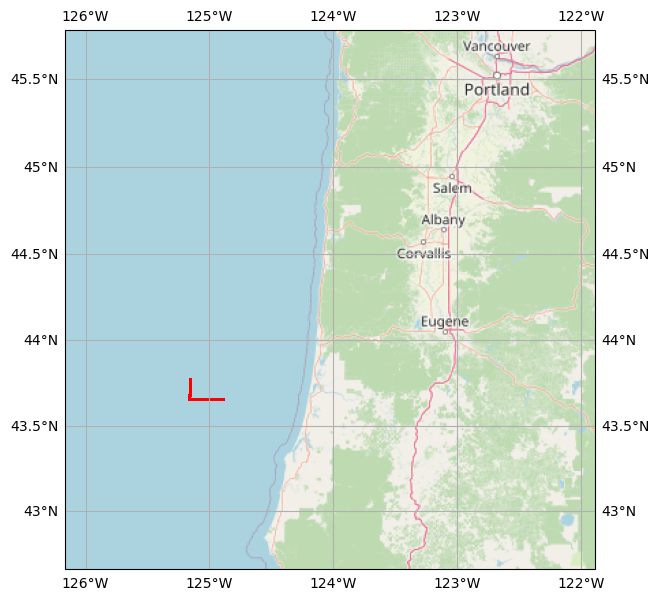

In [17]:
basemap = cimgt.OSM()
_, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": basemap.crs}
)
bnd = gps_gdf.geometry.bounds
ax.set_extent([bnd.minx.min() - 1, bnd.maxx.max() + 3, 
               bnd.miny.min() - 1, bnd.maxy.max() + 2])
ax.add_image(basemap, 7)
ax.gridlines(draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)
gps_gdf.plot(ax=ax, markersize=0.1, color='red', 
             transform=ccrs.PlateCarree());

## Compute mean volume backscattering strength ($\text{MVBS}$) and plot interactive echograms using `hvplot`

`echopype` supports basic processing funcionalities including calibration (from raw instrument data records to volume backscattering strength, $S_V$), denoising, and computing mean volume backscattering strength, $\overline{S_V}$ or $\text{MVBS}$. The `EchoData` object can be passed into various calibration and preprocessing functions without having to write out any intermediate files.

We'll calibrate the combined backscatter data to obtain $S_V$. For EK60 data, by default the function uses environmental (sound speed and absorption) and calibration parameters stored in the data file. Users can optionally specify other parameter choices. $S_V$ is then binned along range (depth) and ping time to generate $\text{MVBS}$.

In [18]:
Sv_ds = ep.calibrate.compute_Sv(combined_ed).compute()
MVBS_ds = ep.commongrid.compute_MVBS(
    Sv_ds,
    range_bin= '5m',  # in meters
    ping_time_bin='20s'  # in seconds
)

In [19]:
Sv_ds

<xarray.Dataset> Size: 452MB
Dimensions:                        (channel: 3, ping_time: 2379,
                                    range_sample: 3957, filenames: 1)
Coordinates:
  * channel                        (channel) <U37 444B 'GPT  18 kHz 009072058...
  * ping_time                      (ping_time) datetime64[ns] 19kB 2017-07-28...
  * range_sample                   (range_sample) int64 32kB 0 1 2 ... 3955 3956
  * filenames                      (filenames) int64 8B 0
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 226MB ...
    echo_range                     (channel, ping_time, range_sample) float64 226MB ...
    frequency_nominal              (channel) float64 24B 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 57kB 1.481e+0...
    sound_absorption               (channel, ping_time) float64 57kB 0.002822...
    sa_correction                  (channel, ping_time) float64 57kB -0.7 ......
    ...                             ...
    angle_sensitivity_alongship    (channel) float64 24B 13.89 21.97 23.12
    angle_sensitivity_athwartship  (channel) float64 24B 13.89 21.97 23.12
    beamwidth_alongship            (channel) float64 24B 10.9 6.81 6.58
    beamwidth_athwartship          (channel) float64 24B 10.82 6.85 6.52
    source_filenames               (filenames) <U26 104B 'SOURCE FILE NOT IDE...
    water_level                    float64 8B 9.15
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.8.4
    processing_time:              2024-04-25T21:30:48Z
    processing_function:          calibrate.compute_Sv

In [20]:
MVBS_ds

<xarray.Dataset> Size: 1MB
Dimensions:            (channel: 3, ping_time: 391, echo_range: 150)
Coordinates:
  * ping_time          (ping_time) datetime64[ns] 3kB 2017-07-28T18:16:00 ......
  * channel            (channel) <U37 444B 'GPT  18 kHz 009072058c8d 1-1 ES18...
  * echo_range         (echo_range) float64 1kB 0.0 5.0 10.0 ... 740.0 745.0
Data variables:
    Sv                 (channel, ping_time, echo_range) float64 1MB -15.13 .....
    water_level        float64 8B 9.15
    frequency_nominal  (channel) float64 24B 1.8e+04 3.8e+04 1.2e+05
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.8.4
    processing_time:              2024-04-25T21:30:50Z
    processing_function:          commongrid.compute_MVBS

Replace the `channel` dimension and coordinate with the `frequency_nominal` variable containing actual frequency values. Note that this step is possible only because there are no duplicated frequencies present.

In [21]:
MVBS_ds = ep.consolidate.swap_dims_channel_frequency(MVBS_ds)

List the three frequencies used by the echosounder

In [22]:
MVBS_ds.frequency_nominal.values

array([ 18000.,  38000., 120000.])

Generate an interactive plot of the three $\text{MVBS}$ echograms, one for each frequency. The frequency can be changed via the slider widget.

In [23]:
import panel as pn
mvplot = MVBS_ds["Sv"].hvplot.image(
    x='ping_time', y='echo_range', 
    color='Sv', rasterize=True, 
    cmap='jet', clim=(-80, -50),
    xlabel='Time (UTC)',
    ylabel='Depth (m)'
).options(width=500, invert_yaxis=True)
pn.panel(mvplot, center=True, widget_layout=pn.Row, widget_location='top_left')

Row(sizing_mode='stretch_width')
    [0] HSpacer()
    [1] Column
        [0] Row
            [0] DiscreteSlider(name='Transducer frequency (..., options={'18000': 18000.0, ...}, value=18000.0)
        [1] HoloViews(DynamicMap, center=True, height=300, sizing_mode='fixed', widget_layout=<class 'panel.layout.base...., widget_location='top_left', width=500)
    [2] HSpacer()

## Package versions

In [24]:
import datetime
import numba, numpy, datashader, holoviews, s3fs, aiobotocore, botocore
print(f"echopype: {ep.__version__}")
print(
    f"numpy: {numpy.__version__}, numba: {numba.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}\n"
    f"fsspec: {fsspec.__version__}, s3fs: {s3fs.__version__}, aiobotocore: {aiobotocore.__version__}, botocore: {botocore.__version__}\n"
    f"datashader: {datashader.__version__}, holoviews: {holoviews.__version__}, hvplot: {hvplot.__version__}"
)

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.8.4
numpy: 1.26.4, numba: 0.59.1, xarray: 2024.3.0, geopandas: 0.14.3
fsspec: 2024.3.1, s3fs: 2024.3.1, aiobotocore: 2.12.2, botocore: 1.34.51
datashader: 0.16.1, holoviews: 1.18.3, hvplot: 0.9.2

2024-04-25 21:30:51.605884 +00:00
